# LimberJack Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl`


In [2]:
using LinearAlgebra
using Turing
using LimberJack
using DataFrames
using CSV
using YAML
using NPZ
using PythonCall
sacc = pyimport("sacc");

using Plots

using Revise
using MicroCanonicalHMC

LoadError: InitError: InterruptException:
during initialization of module PkgREPL

In [3]:
sacc_path = "/home/jaimerz/PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path = "/home/jaimerz/PhD/LimberJack.jl/data/DECALS/DECALS.yml"
sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)
DECALS_meta, DECALS_files = make_data(sacc_file, yaml_file)

DECALS_data = DECALS_meta.data
DECALS_cov = DECALS_meta.cov;

LoadError: UndefVarError: `sacc` not defined

In [4]:
@model function DECALS_model(data)
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.6)
    Ωb ~ Uniform(0.028, 0.065)
    h ~ TruncatedNormal(72, 5, 0.64, 0.82)
    s8 ~ Uniform(0.4, 1.2)
    ns ~ Uniform(0.84, 1.1)

    DECALS__0_b ~ Uniform(0.8, 3.0)
    DECALS__1_b ~ Uniform(0.8, 3.0)
    DECALS__2_b ~ Uniform(0.8, 3.0)
    DECALS__3_b ~ Uniform(0.8, 3.0)
    DECALS__0_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DECALS__1_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DECALS__2_dz ~ TruncatedNormal(0.0, 0.006, -0.2, 0.2)
    DECALS__3_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)

    nuisances = Dict("DECALS__0_b" => DECALS__0_b,
                     "DECALS__1_b" => DECALS__1_b,
                     "DECALS__2_b" => DECALS__2_b,
                     "DECALS__3_b" => DECALS__3_b,
                     "DECALS__0_dz" => DECALS__0_dz,
                     "DECALS__1_dz" => DECALS__1_dz,
                     "DECALS__2_dz" => DECALS__2_dz,
                     "DECALS__3_dz" => DECALS__3_dz)

    cosmology = Cosmology(Ωm, Ωb, h, ns, s8,
                          tk_mode="EisHu",
                          Pk_mode="Halofit")

    theory = Theory(cosmology, DECALS_meta, DECALS_files; Nuisances=nuisances)
    data ~ MvNormal(theory, DECALS_cov)
end

DECALS_model (generic function with 2 methods)

In [5]:
DECALS_model_cond = DECALS_model(DECALS_data)
DECALS_target = TuringTarget(DECALS_model_cond);

LoadError: UndefVarError: `DECALS_data` not defined

In [6]:
sacc_path = "/home/jaimerz/PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path = "/home/jaimerz/PhD/LimberJack.jl/data/DESY1/DESY1.yml"
sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)
DES_meta, DES_files = make_data(sacc_file, yaml_file)

DES_data = DES_meta.data
DES_cov = DES_meta.cov;

LoadError: UndefVarError: `sacc` not defined

In [7]:
fid_cosmology = Cosmology(0.3, 0.05, 0.7, 0.96, 0.8)
fid_nuisances = Dict("DESgc__0_b" => 1.2,
                 "DESgc__1_b" => 1.4,
                 "DESgc__2_b" => 1.6,
                 "DESgc__3_b" => 1.8,
                 "DESgc__4_b" => 2.0)
fake_DES_data = Theory(fid_cosmology, DES_meta, DES_files; Nuisances=fid_nuisances)

LoadError: UndefVarError: `Cosmology` not defined

In [8]:
@model function DES_model(data)
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.6)
    Ωb ~ Uniform(0.028, 0.065)
    h ~ TruncatedNormal(72, 5, 0.64, 0.82)
    s8 ~ Uniform(0.4, 1.2)
    ns ~ Uniform(0.84, 1.1)

    DESgc__0_b ~ Uniform(0.8, 3.0)
    DESgc__1_b ~ Uniform(0.8, 3.0)
    DESgc__2_b ~ Uniform(0.8, 3.0)
    DESgc__3_b ~ Uniform(0.8, 3.0)
    DESgc__4_b ~ Uniform(0.8, 3.0)
    #DESgc__0_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    #DESgc__1_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    #DESgc__2_dz ~ TruncatedNormal(0.0, 0.006, -0.2, 0.2)
    #DESgc__3_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    #DESgc__4_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    #DESwl__0_dz ~ TruncatedNormal(-0.001, 0.016, -0.2, 0.2)
    #DESwl__1_dz ~ TruncatedNormal(-0.019, 0.013, -0.2, 0.2)
    #DESwl__2_dz ~ TruncatedNormal(0.009, 0.011, -0.2, 0.2)
    #DESwl__3_dz ~ TruncatedNormal(-0.018, 0.022, -0.2, 0.2)
    #DESwl__0_m ~ Normal(0.012, 0.023)
    #DESwl__1_m ~ Normal(0.012, 0.023)
    #DESwl__2_m ~ Normal(0.012, 0.023)
    #DESwl__3_m ~ Normal(0.012, 0.023)
    #A_IA ~ Uniform(-5, 5) 
    #alpha_IA ~ Uniform(-5, 5)

    nuisances = Dict("DESgc__0_b" => DESgc__0_b,
                     "DESgc__1_b" => DESgc__1_b,
                     "DESgc__2_b" => DESgc__2_b,
                     "DESgc__3_b" => DESgc__3_b,
                     "DESgc__4_b" => DESgc__4_b,
                     #"DESgc__0_dz" => DESgc__0_dz,
                     #"DESgc__1_dz" => DESgc__1_dz,
                     #"DESgc__2_dz" => DESgc__2_dz,
                     #"DESgc__3_dz" => DESgc__3_dz,
                     #"DESgc__4_dz" => DESgc__4_dz,
                     #"DESwl__0_dz" => DESwl__0_dz,
                     #"DESwl__1_dz" => DESwl__1_dz,
                     #"DESwl__2_dz" => DESwl__2_dz,
                     #"DESwl__3_dz" => DESwl__3_dz,
                     #"DESwl__0_m" => DESwl__0_m,
                     #"DESwl__1_m" => DESwl__1_m,
                     #"DESwl__2_m" => DESwl__2_m,
                     #"DESwl__3_m" => DESwl__3_m,
                     #"A_IA" => A_IA,
                     #"alpha_IA" => alpha_IA,
                     )

    cosmology = Cosmology(Ωm, Ωb, h, ns, s8,
                          tk_mode="EisHu",
                          Pk_mode="Halofit")

    theory = Theory(cosmology, DES_meta, DES_files; Nuisances=nuisances)
    data ~ MvNormal(theory, DES_cov)
end

DES_model (generic function with 2 methods)

In [9]:
DES_model_cond = DES_model(fake_DES_data)
DES_target = TuringTarget(DES_model_cond);

LoadError: UndefVarError: `fake_DES_data` not defined

## Sampling

In [10]:
DECALS_spl = MCHMC(0.0, sqrt(13); init_eps=0.6, VarE_wanted=0.001, sigma=ones(13))
DES_spl = MCHMC(0.0, sqrt(10); init_eps=0.07, VarE_wanted=0.001, sigma=ones(10));

LoadError: UndefVarError: `MCHMC` not defined

In [11]:
samples= Sample(DES_spl, DES_target, 1_000;
                initial_x = [0.3, 0.05, 0.7, 0.8, 0.96, 1.2, 1.4, 1.6, 1.8, 2.0],
                burn_in=0, dialog=true)

LoadError: UndefVarError: `Sample` not defined

In [28]:
ess, rhat = Summarize(samples)

([1.4602855007480169, 1.3113267799521342, 1.1569589986343032, 2.1986975919677536, 1.4640803539222513, 2.3709491935079616, 2.3856712084710154, 2.5892954380020083, 2.766255725974481, 3.9190096991682353, NaN, 11.646243569689936], [1.8821884547939451, 2.1834312517080785, 3.0008832367757905, 1.3836182241553563, 1.864021915451343, 1.3611616268887754, 1.3470237827787515, 1.3047878483365063, 1.2826345217261845, 1.1888924752488632, NaN, 1.0425853123562658])

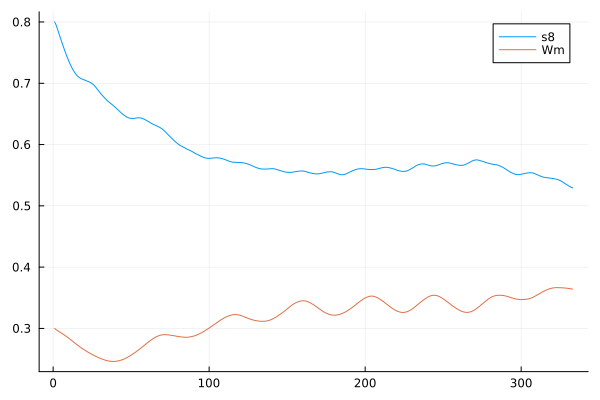

In [29]:
s8s = [sample[4] for sample in samples]
Wms = [sample[1] for sample in samples]
plot(s8s, label="s8")
plot!(Wms, label="Wm")

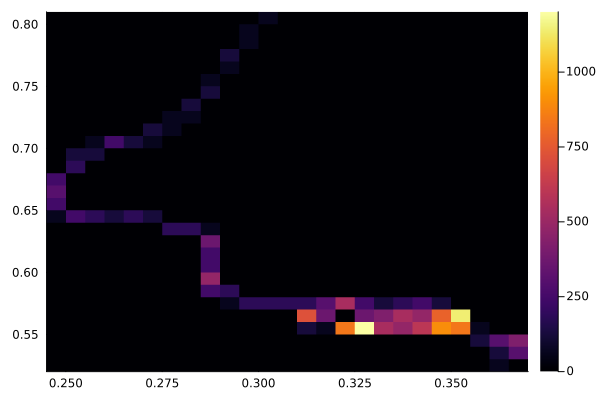

In [30]:
histogram2d(Wms, s8s, bins=(40,40), show_empty_bins=true,
            ranges = [[0.2, 0.4],[0.6, 1.2]], normalize=:pdf)

0.023000136875240114


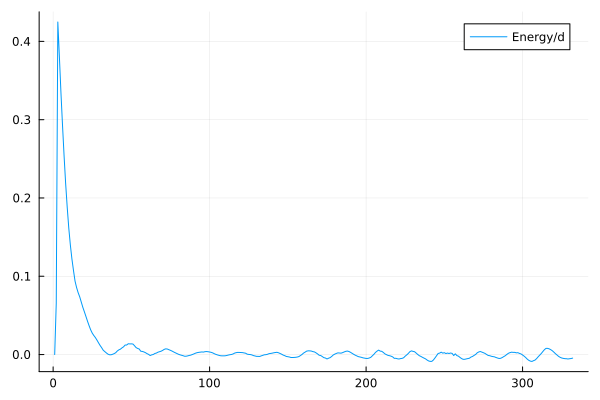

In [31]:
E = [sample[end-1] for sample in samples[1:end-1]]
println(std(E)^2/10)
plot(E./10, label="Energy/d")

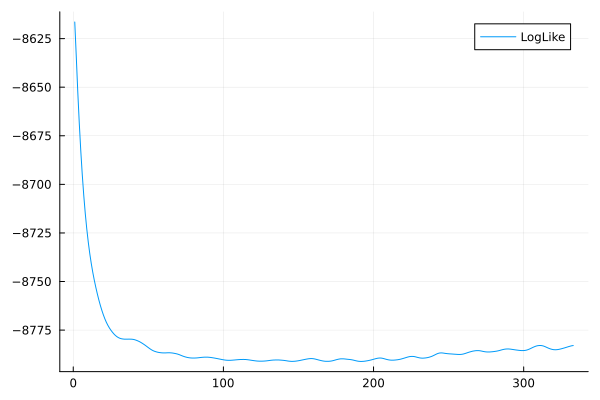

In [32]:
l = [-sample[end] for sample in samples]
plot(l, label="LogLike")

## NUTS

In [39]:
samples_hmc = sample(stat_model, NUTS(100, 0.65),
                     300, progress=true; save_state=true)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling:   4%|█▍                                       |  ETA: 0:02:26┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling: 100%|█████████████████████████████████████████| Time: 1:14:57


Chains MCMC chain (300×25×1 Array{Float64, 3}):

Iterations        = 101:1:400
Number of chains  = 1
Samples per chain = 300
Wall duration     = 4502.67 seconds
Compute duration  = 4502.67 seconds
parameters        = Ωm, Ωb, h, s8, ns, DECALS__0_b, DECALS__1_b, DECALS__2_b, DECALS__3_b, DECALS__0_dz, DECALS__1_dz, DECALS__2_dz, DECALS__3_dz
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse        ess      rhat   ⋯
        Symbol   Float64   Float64    Float64   Float64    Float64   Float64   ⋯

            Ωm    0.2811    0.0226     0.0013    0.0024    98.0312    1.0213   ⋯
            Ωb    0.0402    0.0069     0.0004    0.0005   144.1265    1.0020   ⋯
             h    0.7376    0.0470     0.0027    0.0050   105.2713    1.0019   ⋯
            s8    0.9177   

In [15]:
summary_hmc.ess

25-element Vector{Float64}:
  107.13649180104869
  331.4835789816811
  207.484061400768
  111.64048654758332
  600.4013034569028
  114.39496059843647
  117.33719647252566
  114.56966849849671
  111.15547545924896
  105.06968640469209
  961.3377488207435
  700.0507524844818
  837.2166448905194
  682.3676139298411
  566.0490257440192
  837.5008331222044
  733.9973963424983
  549.1048795030388
  792.5424251430129
 1009.6818545217956
  763.2299996132994
  872.0250289709837
  763.7811879280131
  552.5319549420313
  731.942598764305

In [16]:
Wms_hmc = vec(samples_hmc[!, "Ωm"])
s8s_hmc = vec(samples_hmc[!, "s8"]);

In [17]:
Wm_hmc_ker = ash(Wms_hmc; m=30)
s8_hmc_ker = ash(s8s_hmc; m=30)
Wm_mchmc_ker = ash(Wms_mchmc; m=30)
s8_mchmc_ker = ash(s8s_mchmc; m=30);

LoadError: UndefVarError: `Wms_mchmc` not defined

In [18]:
Plots.plot(Wm_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(Wm_hmc_ker; hist=false, label="HMC", xlabel="Wm")

LoadError: UndefVarError: `Wm_mchmc_ker` not defined

In [19]:
Plots.plot(s8_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(s8_hmc_ker; hist=false, label="HMC",  xlabel="s8")

LoadError: UndefVarError: `s8_mchmc_ker` not defined

## Self-tuning

In [20]:
mchmc = Sampler()
println(string("L = ", mchmc.settings.L, ", eps = ", mchmc.settings.eps))
# This should start self-tuning    

LoadError: UndefVarError: `Sampler` not defined

In [21]:
mchmc.settings.tune_samples

LoadError: UndefVarError: `mchmc` not defined

In [22]:
samples = Sample(mchmc, target; num_steps=10000, dialog=true);

LoadError: UndefVarError: `Sample` not defined